In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

/Users/erichuiza/Documents/pucp/mieriÃÅa web/dev/sesion-de-clase-07/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sns.set(style="whitegrid", context="notebook")

In [4]:
df = pd.read_csv("../datos/comentarios.csv")
textos = df["texto_comentario"].astype(str).tolist()

In [5]:
modelo = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")
embeddings = modelo.encode(textos, show_progress_bar=True)

Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:00<00:00, 25.08it/s]


/Users/erichuiza/Documents/pucp/mieriÃÅa web/dev/sesion-de-clase-07/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


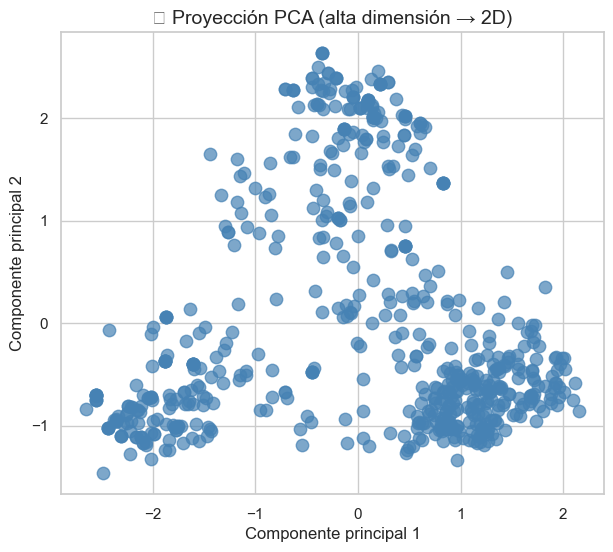

In [6]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)

plt.figure(figsize=(7, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], s=80, alpha=0.7, color="steelblue")
plt.title("Proyecci√≥n PCA (alta dimensi√≥n ‚Üí 2D)", fontsize=14)
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.show()

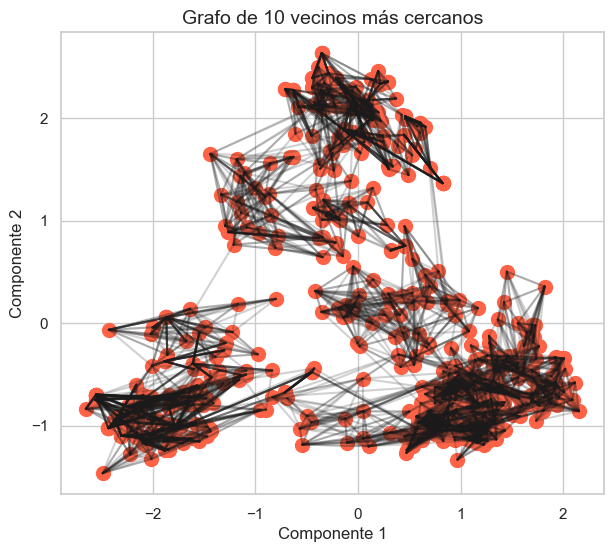

In [18]:
n_neighbors = 10
nn = NearestNeighbors(n_neighbors=n_neighbors, metric="cosine")
nn.fit(embeddings)
distances, indices = nn.kneighbors(embeddings)

# Mostrar conexiones entre puntos
plt.figure(figsize=(7, 6))
for i in range(len(indices)):
    for j in indices[i][1:]:
        plt.plot([pca_result[i, 0], pca_result[j, 0]],
                 [pca_result[i, 1], pca_result[j, 1]], "k-", alpha=0.2)
plt.scatter(pca_result[:, 0], pca_result[:, 1], s=100, color="tomato")
plt.title(f"Grafo de {n_neighbors} vecinos m√°s cercanos", fontsize=14)
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.show()

/Users/erichuiza/Documents/pucp/mieriÃÅa web/dev/sesion-de-clase-07/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


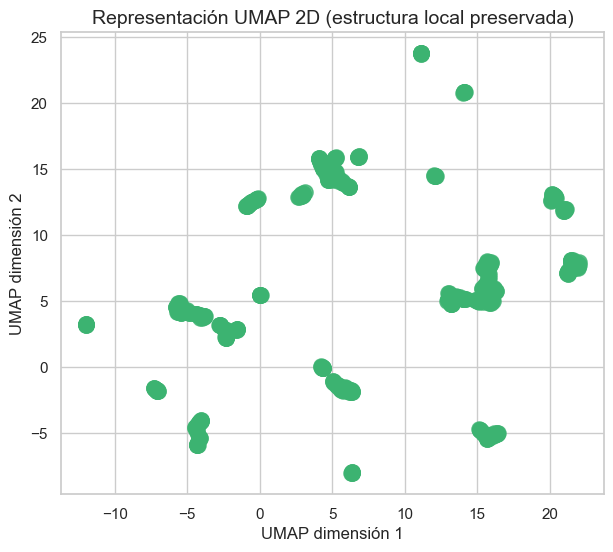

In [38]:
umap_model = umap.UMAP(
    n_neighbors=20,
    n_components=2,
    metric='cosine',
    random_state=42
).fit(embeddings)

umap_2d = umap_model.embedding_

plt.figure(figsize=(7, 6))
plt.scatter(umap_2d[:, 0], umap_2d[:, 1], s=120, alpha=0.8, color="mediumseagreen")
plt.title("Representaci√≥n UMAP 2D (estructura local preservada)", fontsize=14)
plt.xlabel("UMAP dimensi√≥n 1")
plt.ylabel("UMAP dimensi√≥n 2")
plt.show()

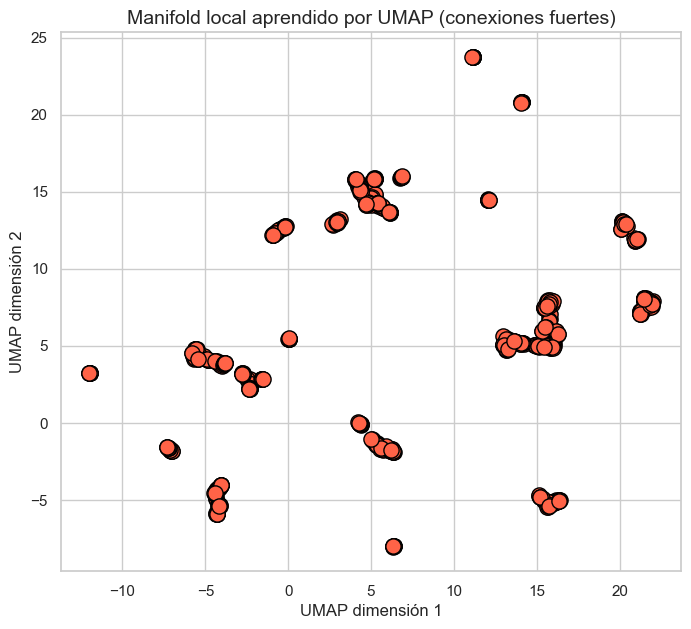

In [39]:
import numpy as np

rows, cols = umap_model.graph_.nonzero()
weights = umap_model.graph_.data

# Normalizamos pesos y filtramos los m√°s fuertes
threshold = np.percentile(weights, 97)
strong_edges = (weights > threshold)

plt.figure(figsize=(8, 7))
for i, j, w in zip(rows[strong_edges], cols[strong_edges], weights[strong_edges]):
    plt.plot(
        [umap_2d[i, 0], umap_2d[j, 0]],
        [umap_2d[i, 1], umap_2d[j, 1]],
        color='lightgray', alpha=0.3, linewidth=0.8
    )

plt.scatter(umap_2d[:, 0], umap_2d[:, 1], s=120, c='tomato', edgecolor='black')
plt.title("Manifold local aprendido por UMAP (conexiones fuertes)", fontsize=14)
plt.xlabel("UMAP dimensi√≥n 1")
plt.ylabel("UMAP dimensi√≥n 2")
plt.show()

In [52]:
import hdbscan

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=15,
    metric='euclidean',
    cluster_selection_method='eom'
).fit(umap_2d)

df["cluster"] = clusterer.labels_
df["probabilidad"] = clusterer.probabilities_

df.head()

/Users/erichuiza/Documents/pucp/mieriÃÅa web/dev/sesion-de-clase-07/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/erichuiza/Documents/pucp/mieriÃÅa web/dev/sesion-de-clase-07/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


id_comentario  id_cliente  id_producto  calificacion  \
0              1           1            2             5   
1              2           2            4             4   
2              3           3            1             5   
3              4           4            5             3   
4              5           5            3             4   

                                    texto_comentario fecha_comentario  \
0  El Smartphone Nexus 5G es un cambio de juego. ...       2024-05-20   
1  La Camiseta Deportiva Ultralight es muy c√≥moda...       2024-05-21   
2  La Laptop Gamer Pro es una bestia de rendimien...       2024-05-22   
3  Las Zapatillas Urbanas Fit tienen un dise√±o mu...       2024-05-23   
4  Los Auriculares Inal√°mbricos X ofrecen un soni...       2024-05-24   

   cluster  probabilidad  
0        9      1.000000  
1        1      1.000000  
2        7      1.000000  
3        1      1.000000  
4        4      0.848249

/var/folders/sl/2x216nz107xcfzxlmr7tr47m0000gn/T/ipykernel_79699/107155654.py:4: UserWarning: 
The palette list has fewer values (12) than needed (13) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(
/Users/erichuiza/Documents/pucp/mieriÃÅa web/dev/sesion-de-clase-07/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


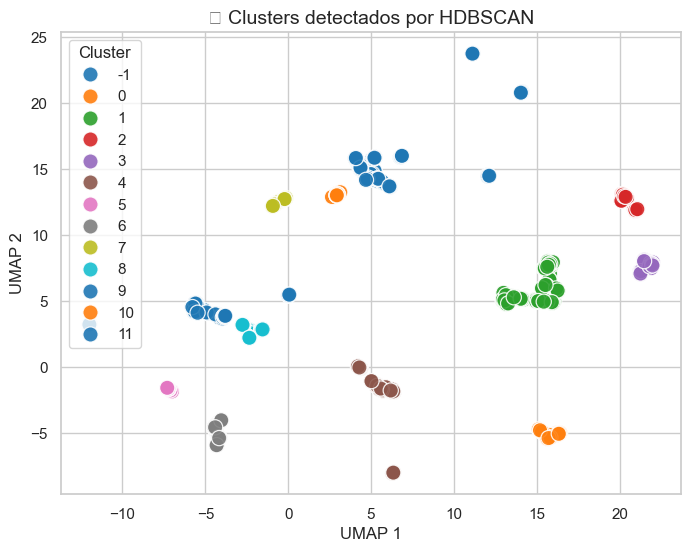

In [53]:
palette = sns.color_palette("tab10", len(set(df["cluster"])) - (1 if -1 in df["cluster"].unique() else 0))

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=umap_2d[:, 0],
    y=umap_2d[:, 1],
    hue=df["cluster"],
    palette=palette,
    s=120,
    alpha=0.9,
    legend="full"
)
plt.title("üß© Clusters detectados por HDBSCAN", fontsize=14)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title="Cluster")
plt.show()


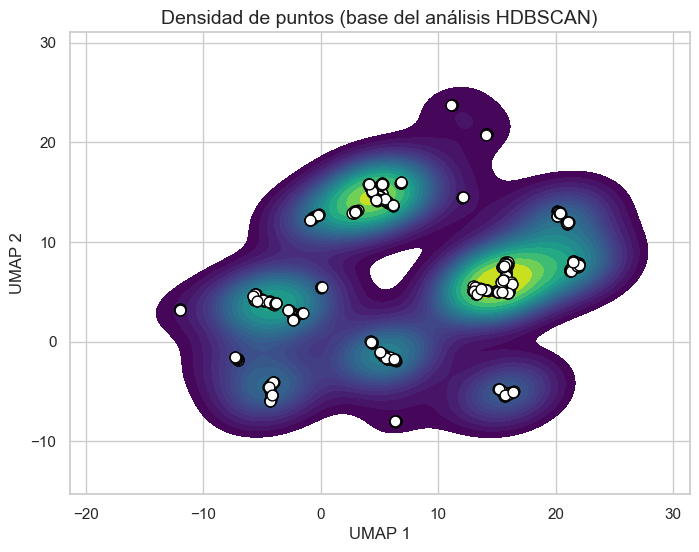

In [42]:
plt.figure(figsize=(8, 6))
sns.kdeplot(x=umap_2d[:, 0], y=umap_2d[:, 1], fill=True, cmap="viridis", levels=20)
plt.scatter(umap_2d[:, 0], umap_2d[:, 1], s=60, color="white", edgecolor="black")
plt.title("Densidad de puntos (base del an√°lisis HDBSCAN)", fontsize=14)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()

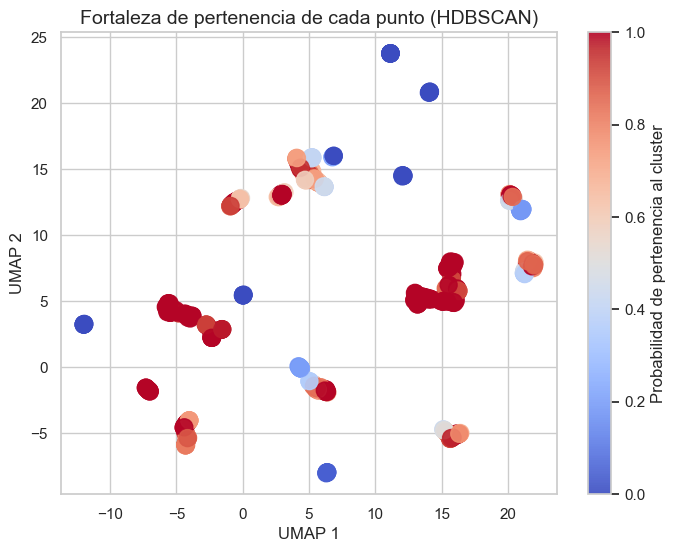

In [43]:
plt.figure(figsize=(8, 6))
plt.scatter(
    umap_2d[:, 0],
    umap_2d[:, 1],
    c=df["probabilidad"],
    cmap="coolwarm",
    s=150,
    alpha=0.9
)
plt.colorbar(label="Probabilidad de pertenencia al cluster")
plt.title("Fortaleza de pertenencia de cada punto (HDBSCAN)", fontsize=14)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()

In [47]:
!python -m spacy download es_core_news_sm

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 12.9/12.9 MB 25.7 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
‚úî Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


In [48]:
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [49]:
nlp = spacy.load("es_core_news_sm")
stopwords = list(nlp.Defaults.stop_words)

docs = df[df["cluster"] != -1]

cluster_docs = docs.groupby("cluster")["texto_comentario"].apply(lambda x: " ".join(x)).reset_index()

vectorizer = CountVectorizer(stop_words=stopwords)
X_counts = vectorizer.fit_transform(cluster_docs["texto_comentario"])

tfidf_transformer = TfidfTransformer(norm=None, use_idf=True, smooth_idf=True)
X_ctfidf = tfidf_transformer.fit_transform(X_counts)

terms = vectorizer.get_feature_names_out()
for i, topic_vector in enumerate(X_ctfidf.toarray()):
    top_indices = topic_vector.argsort()[-10:][::-1]
    top_terms = [terms[idx] for idx in top_indices]
    print(f"\nCluster {cluster_docs.iloc[i]['cluster']} ‚Äî Palabras clave:")
    print(", ".join(top_terms))


üß© Cluster 0 ‚Äî Palabras clave:
trama, personajes, historia, libro, lectura, cost√≥, interesante, entretenida, escritura, confusa

üß© Cluster 1 ‚Äî Palabras clave:
material, mochila, suela, camiseta, c√≥modas, puerto, siente, zapatillas, funcional, usb

üß© Cluster 2 ‚Äî Palabras clave:
bal√≥n, durabilidad, agarre, rebote, consistente, control, desgast√≥, costura, top, dise√±o

üß© Cluster 3 ‚Äî Palabras clave:
ollas, cocina, comida, set, f√°ciles, limpiar, calor, calidad, uniforme, acabado

üß© Cluster 4 ‚Äî Palabras clave:
sonido, auriculares, audio, micr√≥fono, ruido, cancelaci√≥n, calidad, bater√≠a, dura, m√∫sica

üß© Cluster 5 ‚Äî Palabras clave:
acci√≥n, estabilizaci√≥n, 4k, c√°mara, perfecta, video, maravilla, calidad, f√°cil, asombrosa

üß© Cluster 6 ‚Äî Palabras clave:
estabilizaci√≥n, c√°mara, video, calidad, grabar, perfecta, carcasa, resistente, bater√≠a, f√°cil

üß© Cluster 7 ‚Äî Palabras clave:
gamer, pro, laptop, potente, m√°quina, teclado, gr√°fica, tarjeta,

/Users/erichuiza/Documents/pucp/mieriÃÅa web/dev/sesion-de-clase-07/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/erichuiza/Documents/pucp/mieriÃÅa web/dev/sesion-de-clase-07/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


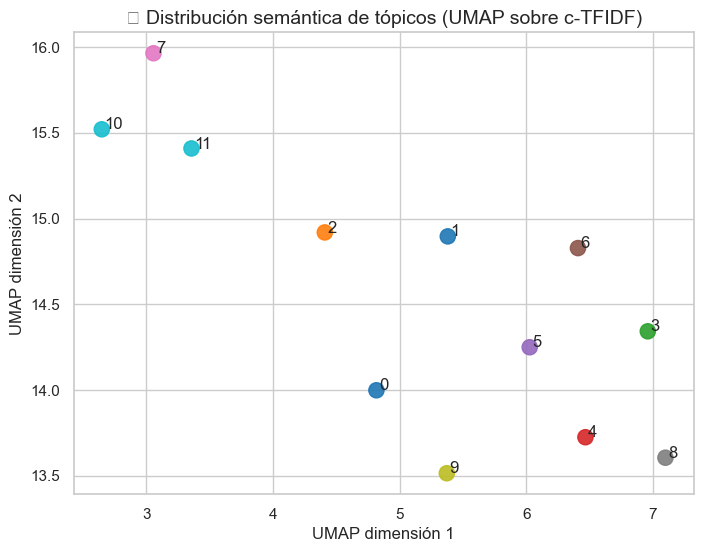

In [50]:
import umap
import matplotlib.pyplot as plt

# Reducimos la matriz c-TFIDF (t√≥picos x t√©rminos) a 2D
umap_model = umap.UMAP(
    n_neighbors=5,
    n_components=2,
    metric='cosine',
    random_state=42
)
embedding_ctfidf = umap_model.fit_transform(X_ctfidf.toarray())

plt.figure(figsize=(8, 6))
plt.scatter(
    embedding_ctfidf[:, 0],
    embedding_ctfidf[:, 1],
    s=120,
    c=cluster_docs["cluster"],
    cmap="tab10",
    alpha=0.9
)
for i, txt in enumerate(cluster_docs["cluster"]):
    plt.text(embedding_ctfidf[i, 0] + 0.02, embedding_ctfidf[i, 1], str(txt), fontsize=12)

plt.title("Distribuci√≥n sem√°ntica de t√≥picos (UMAP sobre c-TFIDF)", fontsize=14)
plt.xlabel("UMAP dimensi√≥n 1")
plt.ylabel("UMAP dimensi√≥n 2")
plt.show()

/Users/erichuiza/Documents/pucp/mieriÃÅa web/dev/sesion-de-clase-07/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9729 (\N{CLOUD}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/erichuiza/Documents/pucp/mieriÃÅa web/dev/sesion-de-clase-07/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


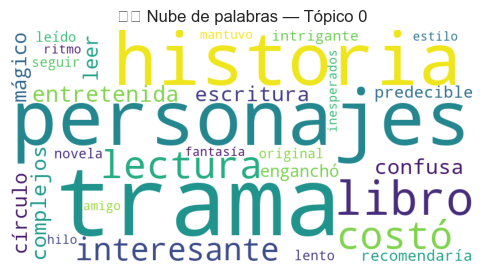

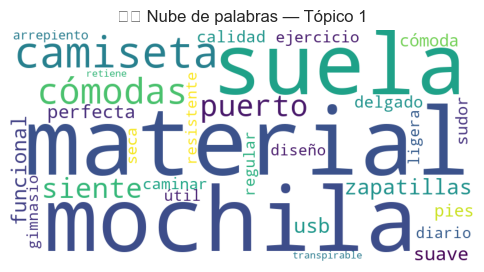

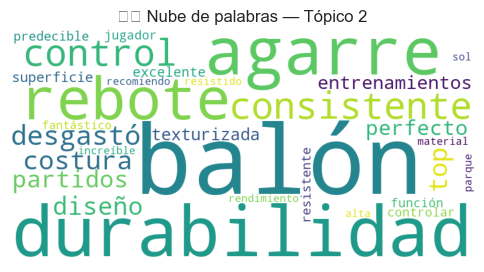

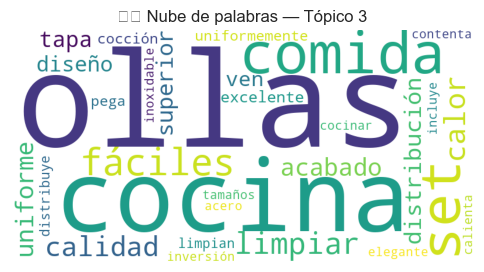

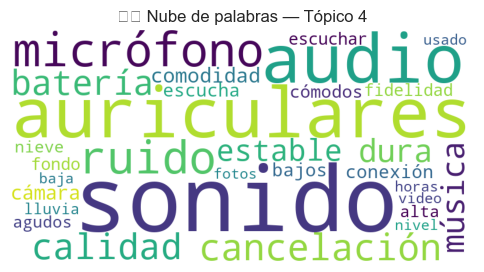

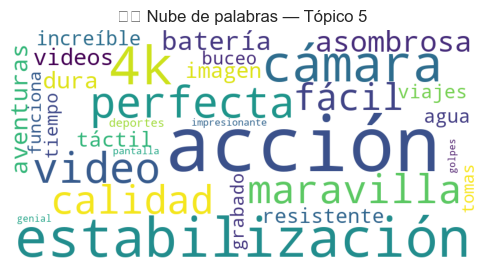

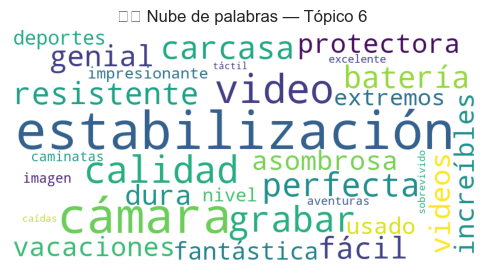

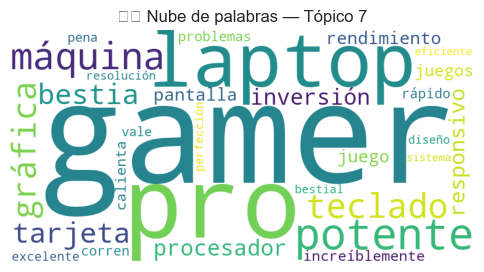

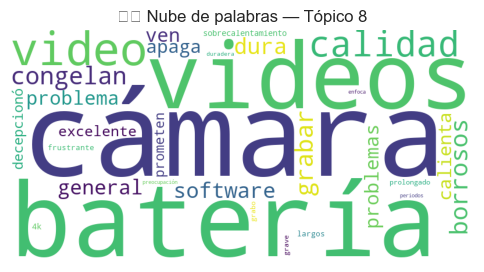

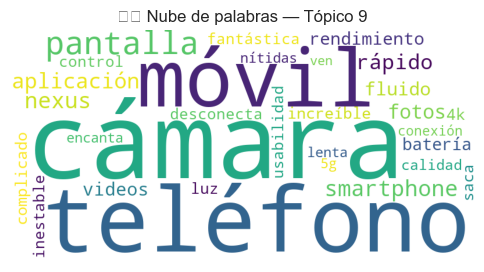

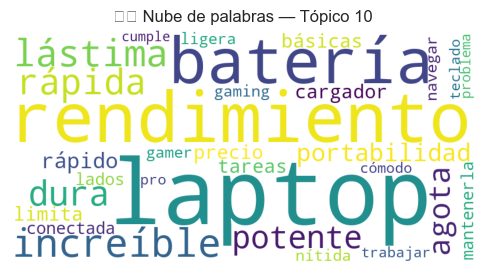

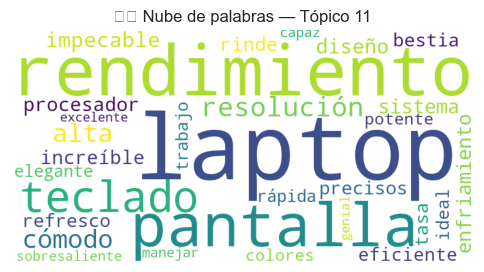

In [51]:
from wordcloud import WordCloud

for i, topic_vector in enumerate(X_ctfidf.toarray()):
    top_indices = topic_vector.argsort()[-30:][::-1]
    top_terms = {terms[idx]: topic_vector[idx] for idx in top_indices}

    plt.figure(figsize=(6, 4))
    plt.imshow(WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(top_terms))
    plt.axis("off")
    plt.title(f"‚òÅÔ∏è Nube de palabras ‚Äî T√≥pico {cluster_docs.iloc[i]['cluster']}")
    plt.show()